# CW + Diversity Regularization on CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

import pickle
import datetime
import glob
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('precision', 10)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# custom code imports
from neuron_coverage import *
from cw_div import *

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
else:
    print('CUDA is not available...')

CUDA is available!


# Loading a Pretrained ResNet56
https://github.com/akamaster/pytorch_resnet_cifar10

In [2]:
from resnet import *

models_dir = 'pretrained_models/cifar10/' 
model = resnet56().cuda()
state_dict = torch.load(models_dir + 'resnet56.th', map_location='cuda')['state_dict'] # best_prec1, state_dict

new_state_dict = {}

for k, v in state_dict.items():
    if 'module' in k:
        k = k.replace('module.', '')
    new_state_dict[k]=v
    
model.load_state_dict(new_state_dict)

print('model loaded!')
# print(model)

model loaded!


# Load Data

In [3]:
data_dir = 'C:\data\CIFAR10'

classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

batch_size = 100 # determines how many of each class we want

def get_same_index(targets, label):
    '''
    Returns indices corresponding to the target label
    which the dataloader uses to serve downstream.
    '''
    label_indices = []
    for i in range(len(targets)):
        if targets[i] == label:
            label_indices.append(i)
    return label_indices

dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                                       train=False, 
                                       download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor()
                                       ]))

test_loader = DataLoader(dataset,
    batch_size=batch_size, 
    shuffle=False,
    pin_memory=True)

Files already downloaded and verified


## Generate per class batches for NC evaluation

In [4]:
# data = []
# labels = []

# for i in range(len(classes)):
    
#     target_indices = get_same_index(dataset.targets, i)
    
#     test_loader = torch.utils.data.DataLoader(dataset,
#         batch_size=batch_size, 
#         sampler=torch.utils.data.sampler.SubsetRandomSampler(target_indices),
#         shuffle=False,
#         num_workers=2, 
#         pin_memory=True)
    
#     inputs, targets = next(iter(test_loader))
    
#     data.append(inputs)
#     labels.append(targets)
    
# # torch.Size([10, batch_size, 3, 32, 32])
# inputs = torch.stack(data).to(device)

# # torch.Size([new_batch_size, 3, 32, 32])
# new_batch_size = len(classes) * batch_size
# all_inputs = inputs.view(new_batch_size,3,32,32)

# # torch.Size([10, batch_size])
# targets = torch.stack(labels).to(device)

# # torch.Size([new_batch_size])
# all_targets = targets.view(-1)

# # individual class performance
# for i in range(len(classes)):
#     # confirm that loading the weights actually worked
#     orig_output = model(inputs[i])
#     orig_pred = torch.argmax(orig_output, dim=1)
#     orig_correct = orig_pred.eq(targets[i].data).sum()
#     orig_acc = 100. * orig_correct / len(targets[i])
#     print(classes[i] + '\t accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(targets[i]), orig_acc))

# # all class performance
# orig_output = model(all_inputs)
# orig_pred = torch.argmax(orig_output, dim=1)
# orig_correct = orig_pred.eq(all_labels.data).sum()
# orig_acc = 100. * orig_correct / len(all_labels)
# print('total accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(all_labels), orig_acc))

In [5]:
# # confirm that all the images are still intact after reshaping the tensor view
# orig_inputs = all_inputs.clone().cpu().detach().numpy()
# for img in orig_inputs:
#     plt.imshow(np.transpose(np.squeeze(img), (1, 2, 0))) 
#     plt.show()

## Evaluate per class and overall accuracy

In [6]:
def get_acc(model, device, test_loader, sampler=False, class_idx=None, classes=None):
    # model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
#             # peek at images to make sure they're of the right class
#             x = 0            
#             if x % 100 == 0:
#                 np_data = data.clone().cpu().detach().numpy()
#                 plt.imshow(np.transpose(np.squeeze(np_data[0]), (1, 2, 0))) 
#                 plt.show()               
#             x += 1
            
    if sampler:
        if class_idx is None:
            raise Exception('you must provide an integer class index if sampler=True')
        if classes is None:
            raise Exception('you must provide an iterable of class indices if sampler=True')
        values, counts = np.unique(test_loader.dataset.targets, return_counts=True) 
        divisor = counts[class_idx]
        acc = 100. * correct / divisor
        print(classes[class_idx] + '\t accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))
    else:
        divisor = len(test_loader.dataset)
        acc = 100. * correct / divisor
        print('accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))

In [7]:
# evaluate on total test set
get_acc(model, device, test_loader)

accuracy: 9107/10000 (91.07%)


In [36]:
# evaluate on each class separately
for i in range(len(classes)):
    
    target_indices = get_same_index(dataset.targets, i)
    
    test_loader = DataLoader(dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(target_indices),
        shuffle=False,
        pin_memory=True)
    
    get_acc(model, device, test_loader, sampler=True, class_idx=i, classes=classes)

plane	 accuracy: 215/1000 (21.50%)
car	 accuracy: 304/1000 (30.40%)
bird	 accuracy: 243/1000 (24.30%)
cat	 accuracy: 244/1000 (24.40%)
deer	 accuracy: 238/1000 (23.80%)
dog	 accuracy: 259/1000 (25.90%)
frog	 accuracy: 188/1000 (18.80%)
horse	 accuracy: 281/1000 (28.10%)
ship	 accuracy: 210/1000 (21.00%)
truck	 accuracy: 262/1000 (26.20%)


# Evaluating Neuron Coverage Per Class

In [16]:
nc_thresholds = np.arange(0,1,0.1)

neuron_coverages_by_class = {}

for i in range(len(classes)):
    
    threshold_results = {}
    
    for t in nc_thresholds:
        
        t = round(t,2)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs[i], t)
        print(classes[i] + ' neuron_coverage_' + str(t), neuron_coverage)

        threshold_results[str(t)] = neuron_coverage
    
    neuron_coverages_by_class[classes[i]] = threshold_results

plane neuron_coverage_0.0 0.8185937764089466


plane neuron_coverage_0.1 0.3672275535690811


plane neuron_coverage_0.2 0.20617100790625176


plane neuron_coverage_0.3 0.11765103570020094


plane neuron_coverage_0.4 0.06495521042648689


plane neuron_coverage_0.5 0.03480816541155703


plane neuron_coverage_0.6 0.018911153261094105


plane neuron_coverage_0.7 0.009525061503502413


plane neuron_coverage_0.8 0.00339912486619467


plane neuron_coverage_0.9 0.0008751338053296776


car neuron_coverage_0.0 0.8338410110987999


car neuron_coverage_0.1 0.39302522113091326


car neuron_coverage_0.2 0.22464271629514168


car neuron_coverage_0.3 0.12897331405284607


car neuron_coverage_0.4 0.07169524310315686


car neuron_coverage_0.5 0.03917632256004808


car neuron_coverage_0.6 0.0200792503145599


car neuron_coverage_0.7 0.0088133110480948


car neuron_coverage_0.8 0.002937144359518489


car neuron_coverage_0.9 0.0006666791864635955


bird neuron_coverage_0.0 0.8354973802324926


bird neuron_coverage_0.1 0.3964224680275686


bird neuron_coverage_0.2 0.21960224605156906


bird neuron_coverage_0.3 0.12486807263986179


bird neuron_coverage_0.4 0.06970271742192341


bird neuron_coverage_0.5 0.039031718905519354


bird neuron_coverage_0.6 0.021420120565644424


bird neuron_coverage_0.7 0.009517549625345076


bird neuron_coverage_0.8 0.0030216529887885217


bird neuron_coverage_0.9 0.0007380420289582903


cat neuron_coverage_0.0 0.8376664350504235


cat neuron_coverage_0.1 0.40234558395462827


cat neuron_coverage_0.2 0.22606997314503557


cat neuron_coverage_0.3 0.12997990572592913


cat neuron_coverage_0.4 0.07498920167514883


cat neuron_coverage_0.5 0.042368870776916


cat neuron_coverage_0.6 0.02293939792296569


cat neuron_coverage_0.7 0.011406786981915154


cat neuron_coverage_0.8 0.003891152885500197


cat neuron_coverage_0.9 0.0008957914702623523


deer neuron_coverage_0.0 0.8410768277338542


deer neuron_coverage_0.1 0.42013746737027924


deer neuron_coverage_0.2 0.24404026366692333


deer neuron_coverage_0.3 0.14266558996413078


deer neuron_coverage_0.4 0.08242596105091175


deer neuron_coverage_0.5 0.04726285939642059


deer neuron_coverage_0.6 0.025470900861988017


deer neuron_coverage_0.7 0.01129410880955511


deer neuron_coverage_0.8 0.0036169693327574226


deer neuron_coverage_0.9 0.0007962590846776465


dog neuron_coverage_0.0 0.8376964825630528


dog neuron_coverage_0.1 0.3934947135157468


dog neuron_coverage_0.2 0.21995154838588518


dog neuron_coverage_0.3 0.12715356156923135


dog neuron_coverage_0.4 0.07310184228811809


dog neuron_coverage_0.5 0.03904298672275536


dog neuron_coverage_0.6 0.020606959755112772


dog neuron_coverage_0.7 0.009649007493098462


dog neuron_coverage_0.8 0.0031155514657552254


dog neuron_coverage_0.9 0.0007117504554076132


frog neuron_coverage_0.0 0.8356720313996507


frog neuron_coverage_0.1 0.40694285338691805


frog neuron_coverage_0.2 0.23220717759957935


frog neuron_coverage_0.3 0.13496779282240043


frog neuron_coverage_0.4 0.07763150481699187


frog neuron_coverage_0.5 0.042182951792521926


frog neuron_coverage_0.6 0.021545944524779807


frog neuron_coverage_0.7 0.009756051756840503


frog neuron_coverage_0.8 0.0032507652725872788


frog neuron_coverage_0.9 0.0007117504554076132


horse neuron_coverage_0.0 0.8336964074442712


horse neuron_coverage_0.1 0.4045578320719638


horse neuron_coverage_0.2 0.229664406843321


horse neuron_coverage_0.3 0.13203816034103927


horse neuron_coverage_0.4 0.07367837893669364


horse neuron_coverage_0.5 0.03994816804071438


horse neuron_coverage_0.6 0.020640763206820786


horse neuron_coverage_0.7 0.009427407087457042


horse neuron_coverage_0.8 0.003100527709440553


horse neuron_coverage_0.9 0.0007624556329696332


ship neuron_coverage_0.0 0.826280305733441


ship neuron_coverage_0.1 0.37701928674716895


ship neuron_coverage_0.2 0.2104828259685628


ship neuron_coverage_0.3 0.11996093823358185


ship neuron_coverage_0.4 0.06637871133730211


ship neuron_coverage_0.5 0.03523446449698586


ship neuron_coverage_0.6 0.01820315874476516


ship neuron_coverage_0.7 0.009232098255366299


ship neuron_coverage_0.8 0.0037371593832748033


ship neuron_coverage_0.9 0.0008488422317790005


truck neuron_coverage_0.0 0.830496347349246


truck neuron_coverage_0.1 0.3855490243948243


truck neuron_coverage_0.2 0.21524911265939267


truck neuron_coverage_0.3 0.12043043061841537


truck neuron_coverage_0.4 0.06625852128678472


truck neuron_coverage_0.5 0.03556686510544799


truck neuron_coverage_0.6 0.01858063062217131


truck neuron_coverage_0.7 0.008452740896542658


truck neuron_coverage_0.8 0.002916486694585814


truck neuron_coverage_0.9 0.0007474318766549607


In [17]:
save_file_path = "assets/neuron_coverages_cifar10_10.pkl"
pickle.dump(neuron_coverages_by_class, open(save_file_path, "wb")) 

In [21]:
df = pd.DataFrame.from_dict(neuron_coverages_by_class)
df.to_clipboard(excel=True)

## Create Extreme Case Inputs

In [41]:
input_shape = (batch_size, 3, 32, 32)
all_blacks = torch.zeros(input_shape).to(device)
all_whites = torch.ones(input_shape).to(device)

In [42]:
covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_blacks, 0.0)
print('all_blacks neuron_coverage', neuron_coverage)

covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_whites, 0.0)
print('all_whites neuron_coverage', neuron_coverage)


all_blacks neuron_coverage 0.42952919303648895



all_whites neuron_coverage 0.439799808447107


# Layer Specific Activations

In [5]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

In [4]:
# load the results from file
with open('assets/results_cifar10_2019.08.15.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [109]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,conv1-0,0,0.93,0.29,0.9519446375,0.2772991042,0.0565550527,0.0133410956
1,cw_div4_attack,conv1-0,0,0.93,0.00,0.9516666980,0.2783451332,0.0568686736,0.0134500178
2,cw_div4_attack,conv1-0,0,0.93,0.00,0.9514075382,0.2791075889,0.0569043550,0.0134068245
3,cw_div4_attack,conv1-0,1,0.93,0.28,0.9522901839,0.2764577739,0.0561663130,0.0133335837
4,cw_div4_attack,conv1-0,1,0.93,0.01,0.9522056752,0.2775864335,0.0563296963,0.0133410956
5,cw_div4_attack,conv1-0,1,0.93,0.00,0.9520948750,0.2790268362,0.0566508291,0.0133861669
6,cw_div4_attack,conv1-0,10,0.93,0.29,0.9523972281,0.2764915773,0.0562339199,0.0133335837
7,cw_div4_attack,conv1-0,10,0.93,0.00,0.9524554452,0.2776315048,0.0564517644,0.0133241939
8,cw_div4_attack,conv1-0,10,0.93,0.01,0.9522732821,0.2788859885,0.0566921445,0.0133673872
9,cw_div4_attack,conv1-0,100,0.93,0.36,0.9525305640,0.2770737479,0.0565118594,0.0132133937


In [26]:
nc_post_reg = {}

thresholds = [0., 0.2]

for t in thresholds:

    inputs_model_layer_dict = get_init_dict(model, inputs, False)
    update_coverage(model, inputs, inputs_model_layer_dict, threshold=t)

    for result in results:

        # reference data
        attack = result['attack']
        layer = result['layer']
        rw = result['regularization_weight']
        conf = result['confidence']
        pert_acc = result['pert_acc']
        adversaries = result['adversaries']

        print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)

        o_covered_neurons, o_total_neurons, o_neuron_coverage = neurons_covered(inputs_model_layer_dict, layer)
        a_covered_neurons, a_total_neurons, a_neuron_coverage = eval_nc(model, adversaries, t, layer)
        
        pct_diff = (a_covered_neurons - o_covered_neurons) / o_covered_neurons

        print(o_covered_neurons, o_total_neurons, o_neuron_coverage)
        print(a_covered_neurons, a_total_neurons, a_neuron_coverage)
        
        nc_post_reg[(t, layer, rw, conf)] = {
            'o_covered_neurons':o_covered_neurons,
            'o_total_neurons':o_total_neurons,
            'o_neuron_coverage':o_neuron_coverage,
            'a_covered_neurons':a_covered_neurons,
            'a_total_neurons':a_total_neurons,
            'a_neuron_coverage':a_neuron_coverage,
            'pct_diff':pct_diff
        }

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


14466 16384 0.8829345703125
14488 16384 0.88427734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


14466 16384 0.8829345703125
14441 16384 0.88140869140625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


14466 16384 0.8829345703125
14453 16384 0.88214111328125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


14466 16384 0.8829345703125
14441 16384 0.88140869140625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


14466 16384 0.8829345703125
14435 16384 0.88104248046875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


14466 16384 0.8829345703125
14443 16384 0.88153076171875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.29


14466 16384 0.8829345703125
14502 16384 0.8851318359375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


14466 16384 0.8829345703125
14510 16384 0.8856201171875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


14466 16384 0.8829345703125
14488 16384 0.88427734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.36


14466 16384 0.8829345703125
14537 16384 0.88726806640625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


14466 16384 0.8829345703125
14585 16384 0.89019775390625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


14466 16384 0.8829345703125
14581 16384 0.88995361328125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.59


14466 16384 0.8829345703125
14686 16384 0.8963623046875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


14466 16384 0.8829345703125
14715 16384 0.89813232421875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.02


14466 16384 0.8829345703125
14673 16384 0.89556884765625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


14466 16384 0.8829345703125
14947 16384 0.91229248046875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.12


14466 16384 0.8829345703125
14935 16384 0.91156005859375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.03


14466 16384 0.8829345703125
14995 16384 0.91522216796875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


15372 16384 0.938232421875
15373 16384 0.93829345703125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


15372 16384 0.938232421875
15375 16384 0.93841552734375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15376 16384 0.9384765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.26


15372 16384 0.938232421875
15372 16384 0.938232421875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.03


15372 16384 0.938232421875
15373 16384 0.93829345703125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15375 16384 0.93841552734375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


15372 16384 0.938232421875
15373 16384 0.93829345703125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


15372 16384 0.938232421875
15377 16384 0.93853759765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15377 16384 0.93853759765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.41


15372 16384 0.938232421875
15382 16384 0.9388427734375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


15372 16384 0.938232421875
15385 16384 0.93902587890625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15386 16384 0.9390869140625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.56


15372 16384 0.938232421875
15402 16384 0.9400634765625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


15372 16384 0.938232421875
15404 16384 0.940185546875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15404 16384 0.940185546875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


15372 16384 0.938232421875
15421 16384 0.94122314453125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.0


15372 16384 0.938232421875
15413 16384 0.94073486328125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


15372 16384 0.938232421875
15422 16384 0.9412841796875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


7943 8192 0.9696044921875
7935 8192 0.9686279296875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


7943 8192 0.9696044921875
7935 8192 0.9686279296875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
7931 8192 0.9681396484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


7943 8192 0.9696044921875
7937 8192 0.9688720703125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


7943 8192 0.9696044921875
7933 8192 0.9683837890625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
7931 8192 0.9681396484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.34


7943 8192 0.9696044921875
7953 8192 0.9708251953125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


7943 8192 0.9696044921875
7948 8192 0.97021484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


7943 8192 0.9696044921875
7952 8192 0.970703125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.51


7943 8192 0.9696044921875
7988 8192 0.97509765625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.05


7943 8192 0.9696044921875
7988 8192 0.97509765625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.01


7943 8192 0.9696044921875
8001 8192 0.9766845703125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.65


7943 8192 0.9696044921875
8033 8192 0.9805908203125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.18


7943 8192 0.9696044921875
8034 8192 0.980712890625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
8048 8192 0.982421875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.63


7943 8192 0.9696044921875
8044 8192 0.98193359375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.07


7943 8192 0.9696044921875
8050 8192 0.982666015625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


7943 8192 0.9696044921875
8055 8192 0.9832763671875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


8121 8192 0.9913330078125
8120 8192 0.9912109375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


8121 8192 0.9913330078125
8117 8192 0.9908447265625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8109 8192 0.9898681640625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.27


8121 8192 0.9913330078125
8119 8192 0.9910888671875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.0


8121 8192 0.9913330078125
8118 8192 0.990966796875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8119 8192 0.9910888671875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


8121 8192 0.9913330078125
8133 8192 0.9927978515625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.01


8121 8192 0.9913330078125
8131 8192 0.9925537109375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8132 8192 0.99267578125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.53


8121 8192 0.9913330078125
8136 8192 0.9931640625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.1


8121 8192 0.9913330078125
8143 8192 0.9940185546875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.05


8121 8192 0.9913330078125
8140 8192 0.99365234375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.77


8121 8192 0.9913330078125
8162 8192 0.996337890625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.09


8121 8192 0.9913330078125
8163 8192 0.9964599609375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


8121 8192 0.9913330078125
8170 8192 0.997314453125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.74


8121 8192 0.9913330078125
8161 8192 0.9962158203125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.04


8121 8192 0.9913330078125
8169 8192 0.9971923828125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.01


8121 8192 0.9913330078125
8172 8192 0.99755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


4093 4096 0.999267578125
4091 4096 0.998779296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


4093 4096 0.999267578125
4092 4096 0.9990234375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.25


4093 4096 0.999267578125
4093 4096 0.999267578125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.02


4093 4096 0.999267578125
4092 4096 0.9990234375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


4093 4096 0.999267578125
4093 4096 0.999267578125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.39


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.02


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.06


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.6


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.23


4093 4096 0.999267578125
4094 4096 0.99951171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.04


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.72


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.1


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.76


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.17


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.02


4093 4096 0.999267578125
4095 4096 0.999755859375
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


9 10 0.9
9 10 0.9
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


9 10 0.9
9 10 0.9
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


9 10 0.9
9 10 0.9


attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


1358 16384 0.0828857421875
1359 16384 0.08294677734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


1358 16384 0.0828857421875
1356 16384 0.082763671875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


1358 16384 0.0828857421875
1357 16384 0.08282470703125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


1358 16384 0.0828857421875
1358 16384 0.0828857421875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


1358 16384 0.0828857421875
1359 16384 0.08294677734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


1358 16384 0.0828857421875
1359 16384 0.08294677734375
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.29


1358 16384 0.0828857421875
1358 16384 0.0828857421875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


1358 16384 0.0828857421875
1362 16384 0.0831298828125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


1358 16384 0.0828857421875
1361 16384 0.08306884765625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.36


1358 16384 0.0828857421875
1360 16384 0.0830078125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


1358 16384 0.0828857421875
1360 16384 0.0830078125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


1358 16384 0.0828857421875
1364 16384 0.083251953125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.59


1358 16384 0.0828857421875
1362 16384 0.0831298828125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


1358 16384 0.0828857421875
1363 16384 0.08319091796875
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.02


1358 16384 0.0828857421875
1369 16384 0.08355712890625
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


1358 16384 0.0828857421875
1442 16384 0.0880126953125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.12


1358 16384 0.0828857421875
1525 16384 0.09307861328125
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.03


1358 16384 0.0828857421875
1742 16384 0.1063232421875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


4452 16384 0.271728515625
4452 16384 0.271728515625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


4452 16384 0.271728515625
4458 16384 0.2720947265625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4456 16384 0.27197265625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.26


4452 16384 0.271728515625
4454 16384 0.2718505859375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.03


4452 16384 0.271728515625
4459 16384 0.27215576171875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4466 16384 0.2725830078125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


4452 16384 0.271728515625
4467 16384 0.27264404296875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


4452 16384 0.271728515625
4472 16384 0.27294921875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4475 16384 0.27313232421875
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.41


4452 16384 0.271728515625
4513 16384 0.27545166015625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.01


4452 16384 0.271728515625
4520 16384 0.27587890625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4538 16384 0.2769775390625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.56


4452 16384 0.271728515625
4775 16384 0.29144287109375
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.05


4452 16384 0.271728515625
4845 16384 0.29571533203125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
4925 16384 0.30059814453125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.64


4452 16384 0.271728515625
5097 16384 0.31109619140625
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.0


4452 16384 0.271728515625
5234 16384 0.3194580078125
attack: cw_div4_attack - layer: conv1-11 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


4452 16384 0.271728515625
5292 16384 0.322998046875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29


2173 8192 0.2652587890625
2112 8192 0.2578125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


2173 8192 0.2652587890625
2160 8192 0.263671875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
2175 8192 0.2655029296875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.28


2173 8192 0.2652587890625
2152 8192 0.2626953125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.01


2173 8192 0.2652587890625
2194 8192 0.267822265625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
2235 8192 0.2728271484375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.34


2173 8192 0.2652587890625
2315 8192 0.2825927734375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.0


2173 8192 0.2652587890625
2396 8192 0.29248046875
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.01


2173 8192 0.2652587890625
2434 8192 0.297119140625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.51


2173 8192 0.2652587890625
3076 8192 0.37548828125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.05


2173 8192 0.2652587890625
3252 8192 0.39697265625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.01


2173 8192 0.2652587890625
3533 8192 0.4312744140625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.65


2173 8192 0.2652587890625
4107 8192 0.5013427734375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.18


2173 8192 0.2652587890625
4400 8192 0.537109375
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
4597 8192 0.5611572265625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.63


2173 8192 0.2652587890625
4304 8192 0.525390625
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.07


2173 8192 0.2652587890625
4777 8192 0.5831298828125
attack: cw_div4_attack - layer: conv2-22 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0


2173 8192 0.2652587890625
4842 8192 0.591064453125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


1114 8192 0.135986328125
1107 8192 0.1351318359375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


1114 8192 0.135986328125
1141 8192 0.1392822265625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
1173 8192 0.1431884765625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.27


1114 8192 0.135986328125
1167 8192 0.1424560546875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.0


1114 8192 0.135986328125
1201 8192 0.1466064453125
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
1212 8192 0.14794921875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.32


1114 8192 0.135986328125
1228 8192 0.14990234375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.01


1114 8192 0.135986328125
1255 8192 0.1531982421875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
1277 8192 0.1558837890625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.53


1114 8192 0.135986328125
1570 8192 0.191650390625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.1


1114 8192 0.135986328125
1750 8192 0.213623046875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.05


1114 8192 0.135986328125
1907 8192 0.2327880859375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.77


1114 8192 0.135986328125
2196 8192 0.26806640625
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.09


1114 8192 0.135986328125
2414 8192 0.294677734375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


1114 8192 0.135986328125
2566 8192 0.313232421875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.74


1114 8192 0.135986328125
2439 8192 0.2977294921875
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.04


1114 8192 0.135986328125
2680 8192 0.3271484375
attack: cw_div4_attack - layer: conv1-33 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.01


1114 8192 0.135986328125
2806 8192 0.342529296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.27


1221 4096 0.298095703125
1333 4096 0.325439453125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


1221 4096 0.298095703125
1330 4096 0.32470703125
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


1221 4096 0.298095703125
1343 4096 0.327880859375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.25


1221 4096 0.298095703125
1337 4096 0.326416015625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 5 - pert_acc: 0.02


1221 4096 0.298095703125
1379 4096 0.336669921875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0


1221 4096 0.298095703125
1403 4096 0.342529296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.39


1221 4096 0.298095703125
1486 4096 0.36279296875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 5 - pert_acc: 0.02


1221 4096 0.298095703125
1534 4096 0.37451171875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10 - confidence: 10 - pert_acc: 0.06


1221 4096 0.298095703125
1572 4096 0.3837890625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.6


1221 4096 0.298095703125
1658 4096 0.40478515625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 5 - pert_acc: 0.23


1221 4096 0.298095703125
1679 4096 0.409912109375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 100 - confidence: 10 - pert_acc: 0.04


1221 4096 0.298095703125
1676 4096 0.4091796875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.72


1221 4096 0.298095703125
1774 4096 0.43310546875
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 5 - pert_acc: 0.1


1221 4096 0.298095703125
1894 4096 0.46240234375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0


1221 4096 0.298095703125
1958 4096 0.47802734375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.76


1221 4096 0.298095703125
1769 4096 0.431884765625
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 5 - pert_acc: 0.17


1221 4096 0.298095703125
1903 4096 0.464599609375
attack: cw_div4_attack - layer: conv2-44 - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.02


1221 4096 0.298095703125
1935 4096 0.472412109375
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.31


8 10 0.8
7 10 0.7
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0


8 10 0.8
6 10 0.6
attack: cw_div4_attack - layer: linear-55 - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0


8 10 0.8
6 10 0.6


In [30]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

)


In [31]:
layer_dict

{'conv1-0': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-1': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-2': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-3': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-4': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-5': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-6': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-7': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-8': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-9': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-10': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),

In [27]:
df = pd.DataFrame.from_dict(nc_post_reg)
df.T

o_covered_neurons  o_total_neurons  o_neuron_coverage  \
0.0 conv1-0   0     0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              1     0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              10    0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              100   0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              1000  0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
              10000 0             14466.0          16384.0       0.8829345703   
                    5             14466.0          16384.0       0.8829345703   
                    10            14466.0          16384.0       0.8829345703   
    conv1-11  0     0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              1     0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              10    0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              100   0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              1000  0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
              10000 0             15372.0          16384.0       0.9382324219   
                    5             15372.0          16384.0       0.9382324219   
                    10            15372.0          16384.0       0.9382324219   
    conv2-22  0     0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              1     0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              10    0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              100   0              7943.0           8192.0       0.9696044922   
                    5              7943.0           8192.0       0.9696044922   
                    10             7943.0           8192.0       0.9696044922   
              1000  0              7943.0           819

In [28]:
df.T['pct_diff'].mean()

0.13402441870837203

In [29]:
save_file_path = "assets/nc_post_reg_cifar10.pkl"
pickle.dump(nc_post_reg, open(save_file_path, "wb")) 

# Diversity Regularization applied to ALL layers

In [86]:
# load the results from file
with open('assets/results_cifar10_2019.08.28.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [87]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'confidence', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,confidence,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,0,0,0.93,0.64,0.9521887735,0.2754530602,0.0561080959,0.0132866345
1,cw_div4_attack,10,0,0.93,0.00,0.9520610716,0.2759432102,0.0561325095,0.0131833462
2,cw_div4_attack,20,0,0.93,0.00,0.9514601213,0.2773009822,0.0563578659,0.0132622209
3,cw_div4_attack,0,1,0.93,0.62,0.9522094312,0.2755939079,0.0559428346,0.0132321734
4,cw_div4_attack,10,1,0.93,0.00,0.9520122444,0.2760521324,0.0558132547,0.0131758343
5,cw_div4_attack,20,1,0.93,0.00,0.9514601213,0.2771507446,0.0563503540,0.0131739563
6,cw_div4_attack,0,10,0.93,0.68,0.9520629495,0.2761817123,0.0559334448,0.0130744239
7,cw_div4_attack,10,10,0.93,0.00,0.9516817217,0.2769178764,0.0557062104,0.0131063494
8,cw_div4_attack,20,10,0.93,0.00,0.9514037822,0.2774737554,0.0558977633,0.0129955492
9,cw_div4_attack,0,100,0.93,0.43,0.9516685759,0.2795113523,0.0562921369,0.0130030611


attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 0 - confidence: 0 - pert_acc: 0.64 inception_score 3.158318679887109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


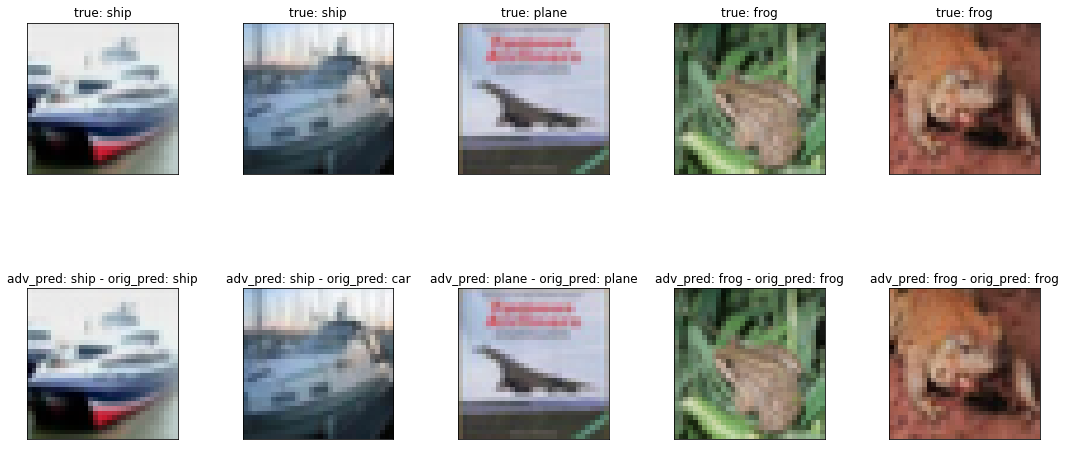

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 0 - confidence: 10 - pert_acc: 0.0 inception_score 3.1480618132140377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


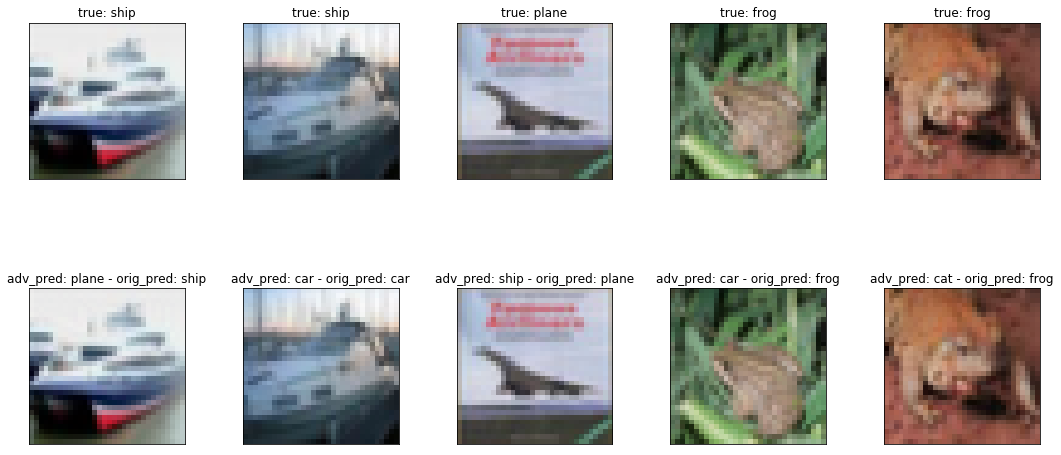

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 0 - confidence: 20 - pert_acc: 0.0 inception_score 3.1495628216614935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


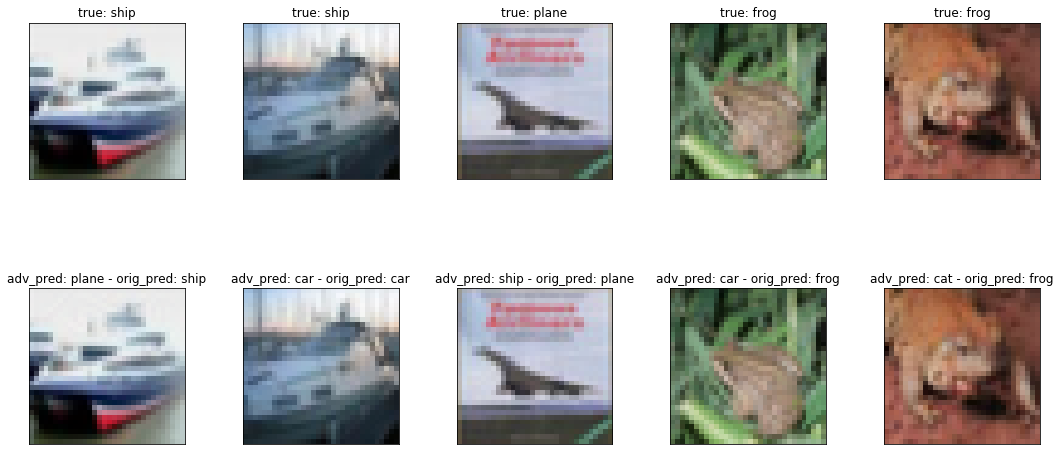

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1 - confidence: 0 - pert_acc: 0.62 inception_score 3.1568809506698456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


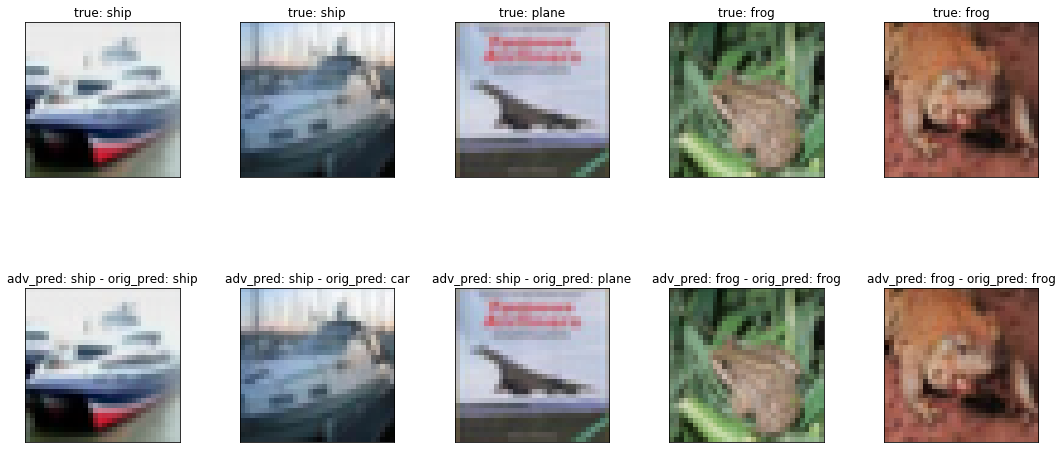

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1 - confidence: 10 - pert_acc: 0.0 inception_score 3.1517342996360442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


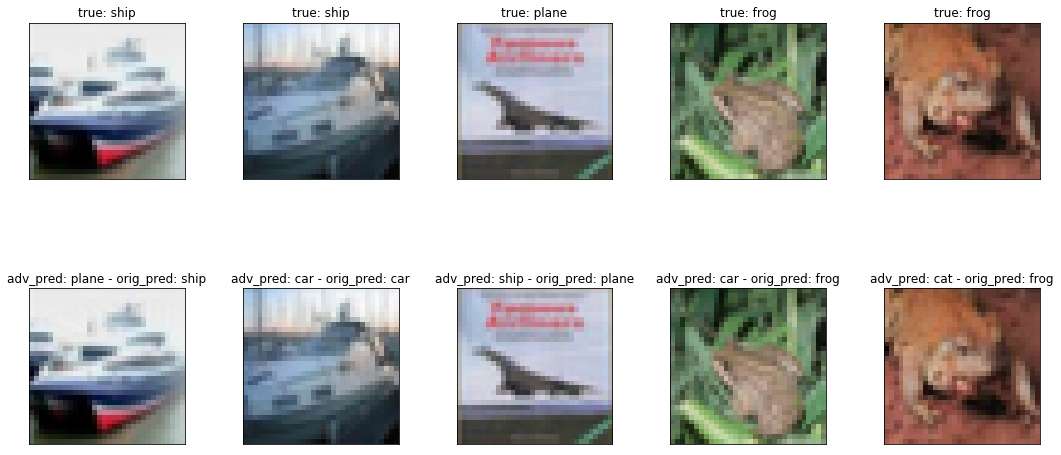

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1 - confidence: 20 - pert_acc: 0.0 inception_score 3.158640993603509


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


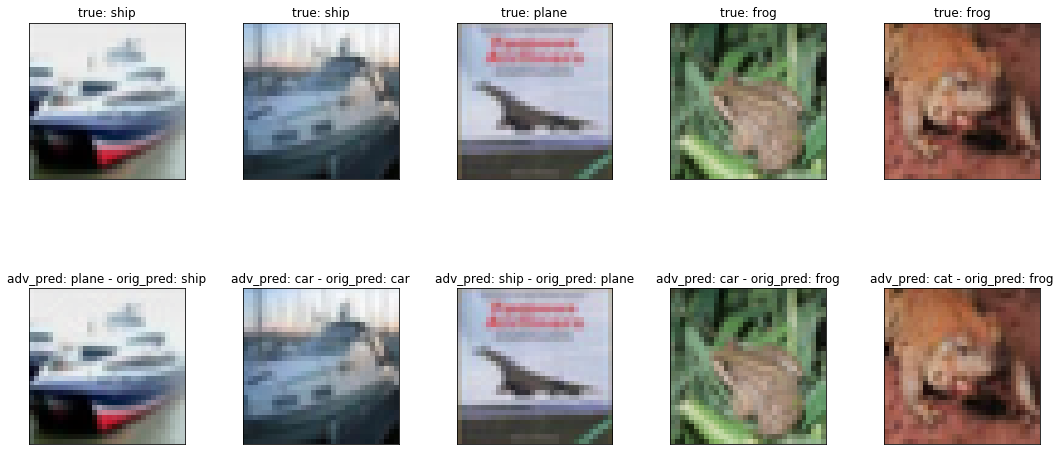

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10 - confidence: 0 - pert_acc: 0.68 inception_score 3.1638990472790227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


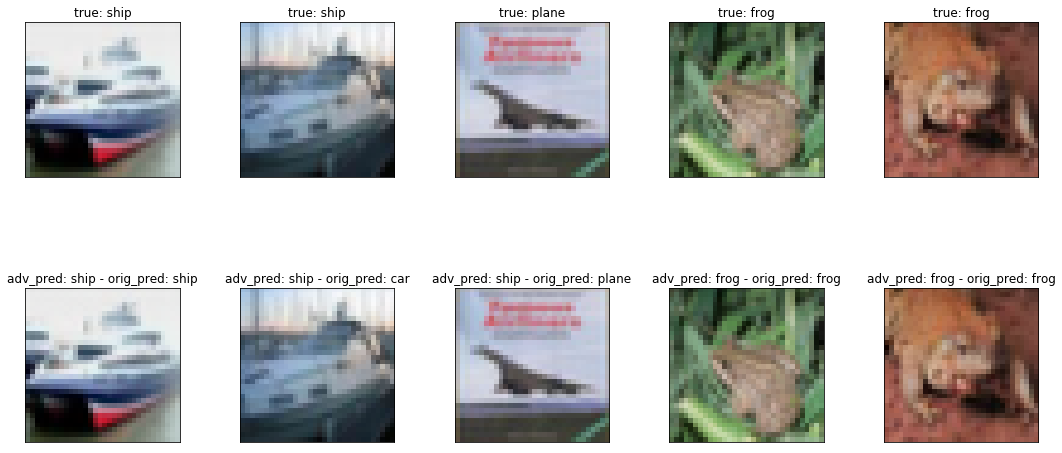

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10 - confidence: 10 - pert_acc: 0.0 inception_score 3.151744257501709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


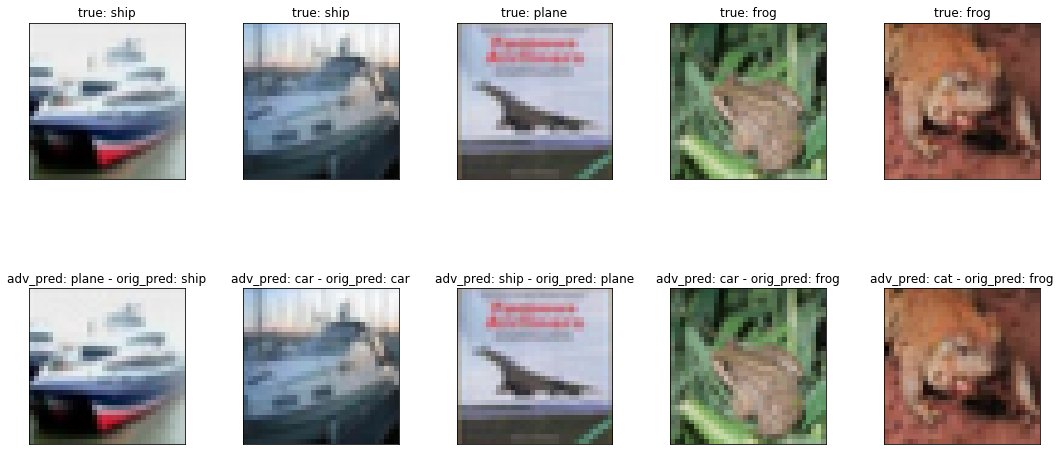

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10 - confidence: 20 - pert_acc: 0.0 inception_score 3.1601570354233375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


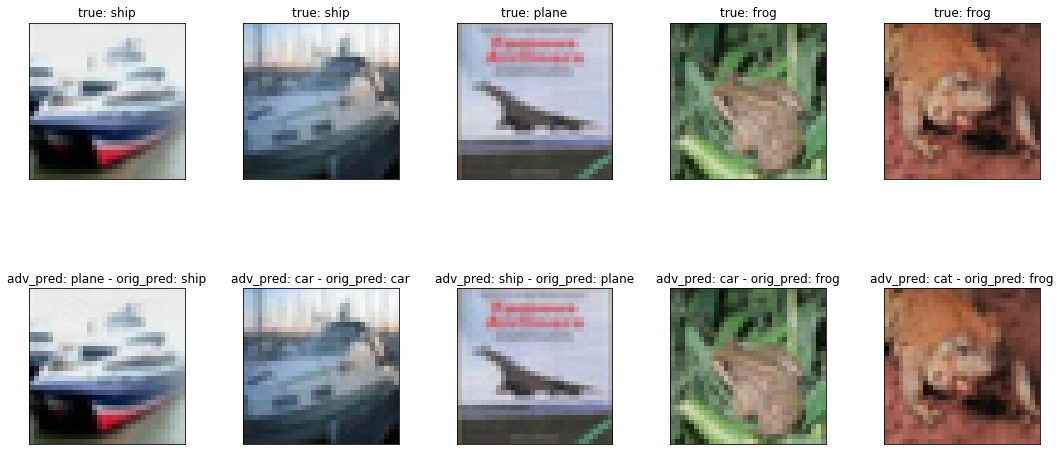

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 100 - confidence: 0 - pert_acc: 0.43 inception_score 3.1569117777961737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


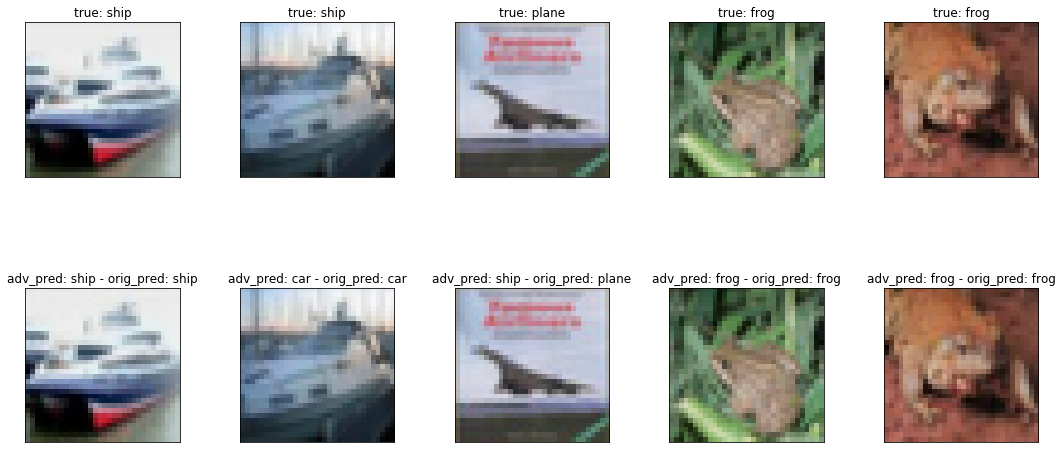

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 100 - confidence: 10 - pert_acc: 0.0 inception_score 3.1521047617788036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


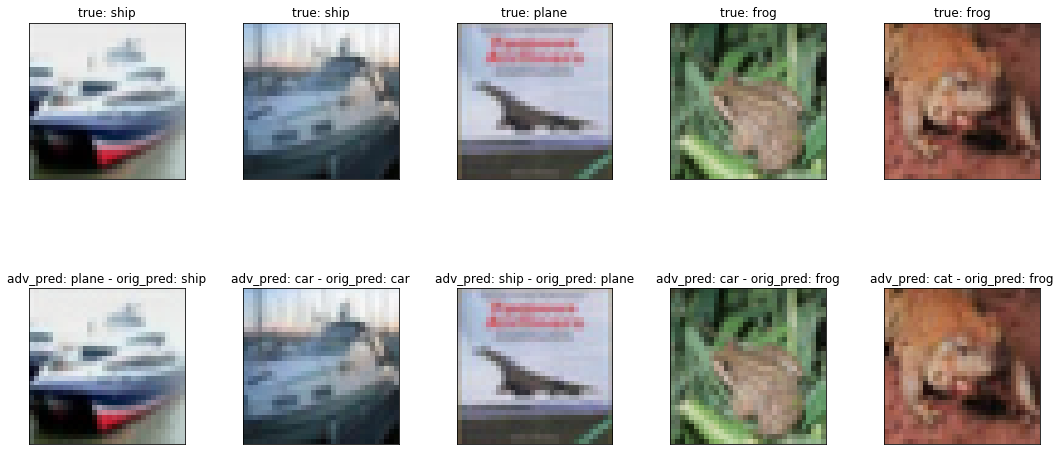

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 100 - confidence: 20 - pert_acc: 0.0 inception_score 3.1136585607744074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


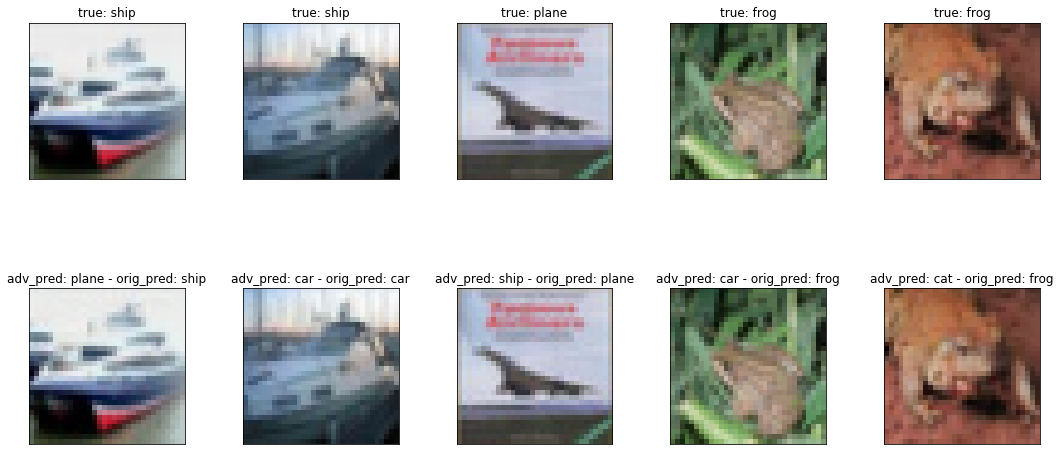

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.51 inception_score 3.03418203094154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


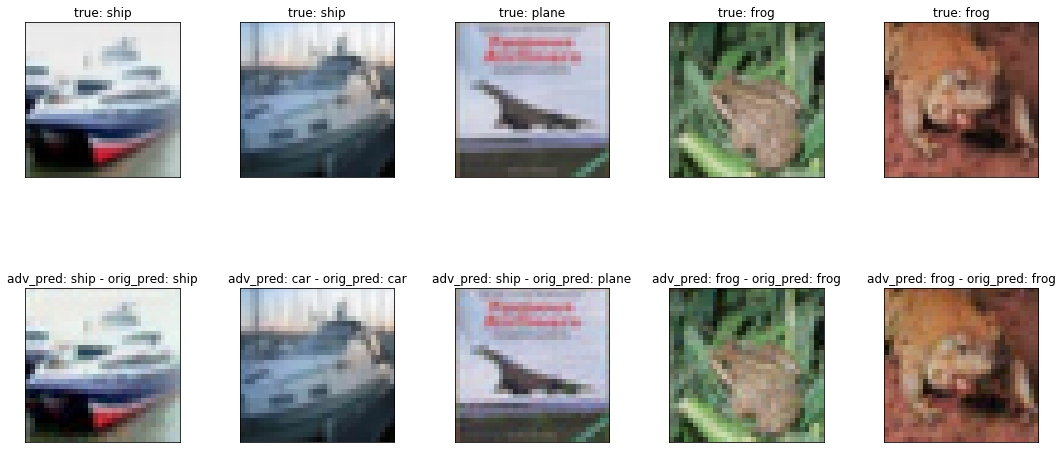

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1000 - confidence: 10 - pert_acc: 0.0 inception_score 2.9469242329892387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


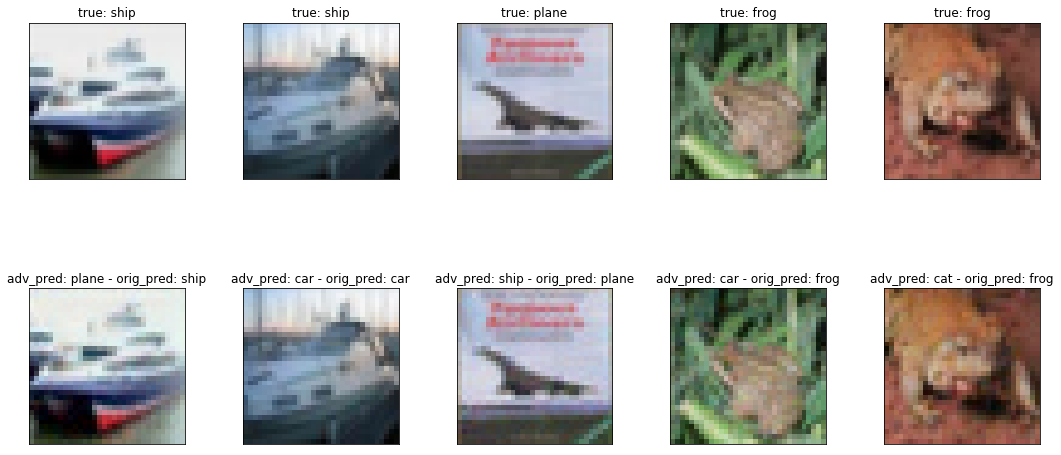

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 1000 - confidence: 20 - pert_acc: 0.0 inception_score 2.871092437217052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


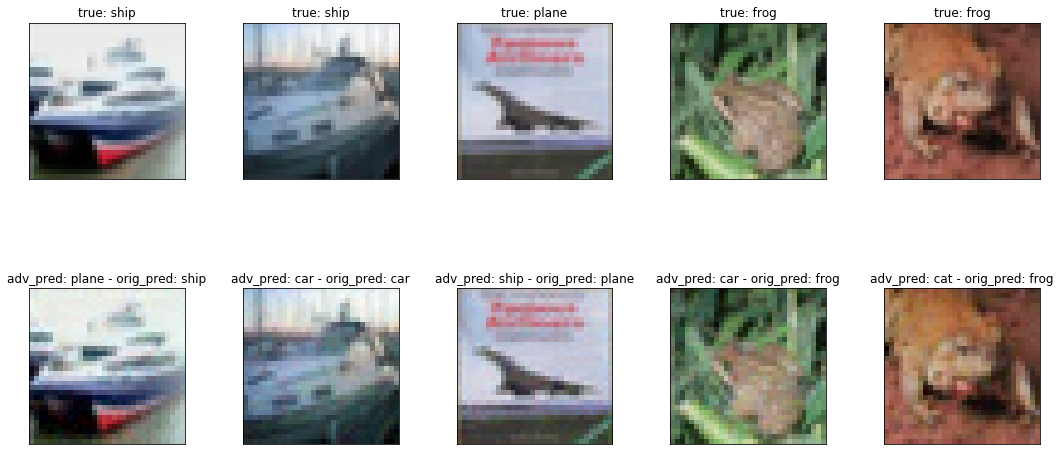

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.67 inception_score 2.4205223662881226


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


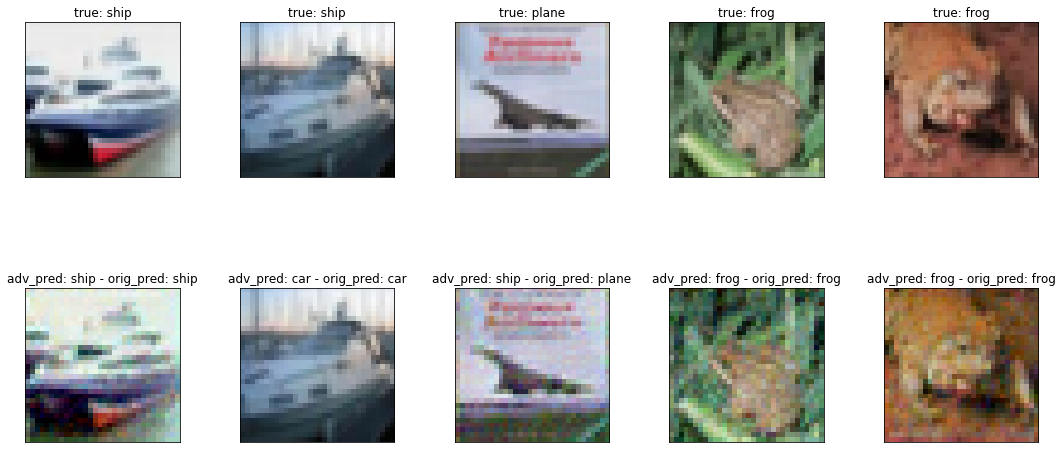

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10000 - confidence: 10 - pert_acc: 0.0 inception_score 2.232126510277692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


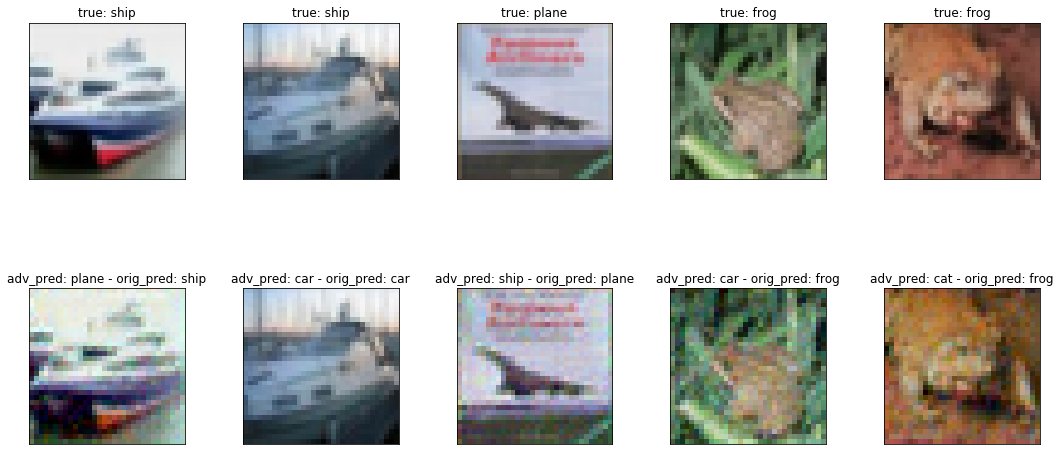

attack: cw_div4_attack - layer: ['conv1-0', 'conv1-11', 'conv2-22', 'conv1-33', 'conv2-44', 'linear-55'] - regularization_weight: 10000 - confidence: 20 - pert_acc: 0.0 inception_score 2.118247882954889


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


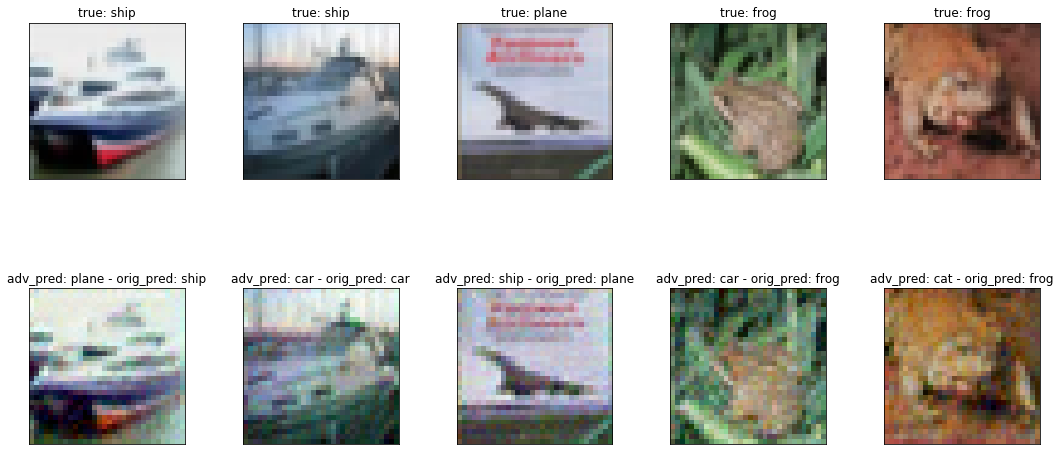

In [89]:
for result in results:
    
    # reference data
    attack = result['attack']
    layers = result['layers']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    adversaries = result['adversaries']
    inception_score = result['inception_score']

    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc, 'inception_score', inception_score)
        
    adversaries = result['adversaries']
    sample_3D_images(model, inputs, adversaries, targets, classes)

# Investigating small NC threshold behavior

In [66]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'confidence', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,confidence,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,0,0,0.93,0.64,0.9521887735,0.2754530602,0.0561080959,0.0132866345
1,cw_div4_attack,10,0,0.93,0.00,0.9520610716,0.2759432102,0.0561325095,0.0131833462
2,cw_div4_attack,20,0,0.93,0.00,0.9514601213,0.2773009822,0.0563578659,0.0132622209
3,cw_div4_attack,0,1,0.93,0.62,0.9522094312,0.2755939079,0.0559428346,0.0132321734
4,cw_div4_attack,10,1,0.93,0.00,0.9520122444,0.2760521324,0.0558132547,0.0131758343
5,cw_div4_attack,20,1,0.93,0.00,0.9514601213,0.2771507446,0.0563503540,0.0131739563
6,cw_div4_attack,0,10,0.93,0.68,0.9520629495,0.2761817123,0.0559334448,0.0130744239
7,cw_div4_attack,10,10,0.93,0.00,0.9516817217,0.2769178764,0.0557062104,0.0131063494
8,cw_div4_attack,20,10,0.93,0.00,0.9514037822,0.2774737554,0.0558977633,0.0129955492
9,cw_div4_attack,0,100,0.93,0.43,0.9516685759,0.2795113523,0.0562921369,0.0130030611


In [39]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

In [40]:
nc_per_threshold = {}

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    
    print('threshold', t)
    
    covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs, t)
    
    print(covered_neurons, total_neurons, neuron_coverage)

    nc_per_threshold[t] = {
        'covered_neurons':covered_neurons,
        'total_neurons':total_neurons,
        'neuron_coverage':neuron_coverage
    }

threshold 0.0


507181 532490 0.952470468928994
threshold 0.01


439025 532490 0.8244755770061409
threshold 0.02


406279 532490 0.7629795864711074
threshold 0.03


378613 532490 0.711023681195891
threshold 0.04


352765 532490 0.6624819245431839
threshold 0.05


329463 532490 0.6187214783376214
threshold 0.06


309340 532490 0.5809310972976018
threshold 0.07


291612 532490 0.5476384533042874
threshold 0.08


275689 532490 0.517735544329471
threshold 0.09


260303 532490 0.48884110499727695
threshold 0.1


245829 532490 0.4616593738849556
threshold 0.11


232238 532490 0.4361358898758662
threshold 0.12


220158 532490 0.4134500178407106
threshold 0.13


208947 532490 0.39239610133523634
threshold 0.14


198426 532490 0.37263798381190255
threshold 0.15


188591 532490 0.354168153392552
threshold 0.16


179608 532490 0.337298353020714
threshold 0.17


170909 532490 0.3209618959980469
threshold 0.18


162411 532490 0.30500291085278597
threshold 0.19


154125 532490 0.2894420552498638
threshold 0.2


145941 532490 0.2740727525399538
threshold 0.21


138069 532490 0.259289376326316
threshold 0.22


130397 532490 0.244881594020545
threshold 0.23


123295 532490 0.23154425435219442
threshold 0.24


116462 532490 0.21871208848992468
threshold 0.25


110161 532490 0.2068790024225807
threshold 0.26


104391 532490 0.19604311818062312
threshold 0.27


98982 532490 0.1858851809423651
threshold 0.28


94031 532490 0.17658735375312212
threshold 0.29


89330 532490 0.16775901894871265
threshold 0.3


84939 532490 0.15951285470149673
threshold 0.31


80887 532490 0.15190332212811508
threshold 0.32


77065 532490 0.14472572254878027
threshold 0.33


73660 532490 0.13833123626734775
threshold 0.34


70444 532490 0.13229168622884938
threshold 0.35000000000000003


67478 532490 0.12672162857518451
threshold 0.36


64490 532490 0.12111025559165431
threshold 0.37


61520 532490 0.11553268605983211
threshold 0.38


58653 532490 0.11014854739056132
threshold 0.39


55752 532490 0.10470055775695318
threshold 0.4


52735 532490 0.09903472365678229
threshold 0.41000000000000003


49858 532490 0.09363180529211816
threshold 0.42


47190 532490 0.08862138256117486
threshold 0.43


44553 532490 0.08366917688595091
threshold 0.44


42073 532490 0.07901181242840241
threshold 0.45


39680 532490 0.07451783132077598
threshold 0.46


37437 532490 0.07030554564404966
threshold 0.47000000000000003


35198 532490 0.06610077184548066
threshold 0.48


33190 532490 0.06232980901049785
threshold 0.49


31314 532490 0.05880673815470713
threshold 0.5


29534 532490 0.05546395237469248
threshold 0.51


27927 532490 0.05244605532498263
threshold 0.52


26377 532490 0.04953520253901482
threshold 0.53


24903 532490 0.0467670754380364
threshold 0.54


23655 532490 0.044423369452947475
threshold 0.55


22437 532490 0.04213600255403857
threshold 0.56


21289 532490 0.03998009352288306
threshold 0.5700000000000001


20203 532490 0.037940618603166255
threshold 0.58


19254 532490 0.036158425510338224
threshold 0.59


18352 532490 0.03446449698585889
threshold 0.6


17514 532490 0.032890758511896934
threshold 0.61


16601 532490 0.03117617232248493
threshold 0.62


15738 532490 0.029555484610039626
threshold 0.63


14865 532490 0.02791601720220098
threshold 0.64


14028 532490 0.026344156697778363
threshold 0.65


13235 532490 0.024854926853086445
threshold 0.66


12471 532490 0.02342015812503521
threshold 0.67


11734 532490 0.022036094574546
threshold 0.68


11014 532490 0.020683956506225468
threshold 0.6900000000000001


10339 532490 0.01941632706717497
threshold 0.7000000000000001


9710 532490 0.01823508422693384
threshold 0.71


9092 532490 0.01707449905162538
threshold 0.72


8535 532490 0.016028470018216303
threshold 0.73


8005 532490 0.015033146162369247
threshold 0.74


7465 532490 0.014019042611128848
threshold 0.75


6975 532490 0.013098837536855153
threshold 0.76


6492 532490 0.012191778249356796
threshold 0.77


5986 532490 0.011241525662453756
threshold 0.78


5445 532490 0.010225544141674023
threshold 0.79


4919 532490 0.0092377321639843
threshold 0.8


4430 532490 0.008319405059249938
threshold 0.81


3974 532490 0.007463050949313602
threshold 0.8200000000000001


3561 532490 0.00668744952956863
threshold 0.8300000000000001


3121 532490 0.005861142932261638
threshold 0.84


2747 532490 0.005158782324550696
threshold 0.85


2410 532490 0.0045259065897951135
threshold 0.86


2088 532490 0.003921200398129542
threshold 0.87


1774 532490 0.0033315179627786437
threshold 0.88


1484 532490 0.002786906796371763
threshold 0.89


1214 532490 0.0022798550207515636
threshold 0.9


987 532490 0.001853555935322729
threshold 0.91


770 532490 0.0014460365452872354
threshold 0.92


581 532490 0.001091100302353096
threshold 0.93


449 532490 0.0008432083231609983
threshold 0.9400000000000001


340 532490 0.0006385096433735844
threshold 0.9500000000000001


257 532490 0.0004826381716088565
threshold 0.96


194 532490 0.00036432609063081
threshold 0.97


146 532490 0.0002741835527427745
threshold 0.98


116 532490 0.00021784446656275235
threshold 0.99


72 532490 0.00013521380683205318
threshold 1.0


0 532490 0.0


In [45]:
df = pd.DataFrame.from_dict(nc_per_threshold).T
df.reset_index(level=0, inplace=True)
df.rename(columns={"index": "threshold"}, inplace=True)
df

,threshold,covered_neurons,total_neurons,neuron_coverage
0,0.00,507181.0,532490.0,0.9524704689
1,0.01,439025.0,532490.0,0.8244755770
2,0.02,406279.0,532490.0,0.7629795865
3,0.03,378613.0,532490.0,0.7110236812
4,0.04,352765.0,532490.0,0.6624819245
5,0.05,329463.0,532490.0,0.6187214783
6,0.06,309340.0,532490.0,0.5809310973
7,0.07,291612.0,532490.0,0.5476384533
8,0.08,275689.0,532490.0,0.5177355443
9,0.09,260303.0,532490.0,0.4888411050


In [46]:
df.corr()

,threshold,covered_neurons,total_neurons,neuron_coverage
threshold,1.0000000000,-0.8308252224,NaN,-0.8308252224
covered_neurons,-0.8308252224,1.0000000000,NaN,1.0000000000
total_neurons,NaN,NaN,NaN,NaN
neuron_coverage,-0.8308252224,1.0000000000,NaN,1.0000000000


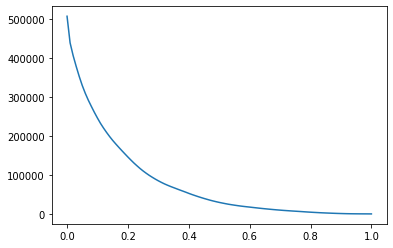

In [47]:
X = df['threshold'].values.reshape(-1, 1)
y = df['covered_neurons'].values.reshape(-1, 1)
plt.plot(X, y)

In [48]:
save_file_path = "assets/nc_threshold_analysis_cifar10.pkl"
pickle.dump(nc_per_threshold, open(save_file_path, "wb")) 

# Investigating how Adversarial Perturbation Affects NC distribution

In [ ]:
nc_per_threshold_adv = {}

thresholds = np.linspace(0, 1, 101)

for result in results:
    
    # reference data
    attack = result['attack']
    layer = result['layer']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    adversaries = result['adversaries']

    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)

    for t in thresholds:

        print('threshold', t)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, adversaries, t)

        print(covered_neurons, total_neurons, neuron_coverage)

        nc_per_threshold_adv[(t, layer, rw, conf)] = {
            'covered_neurons':covered_neurons,
            'total_neurons':total_neurons,
            'neuron_coverage':neuron_coverage
        }

attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.29
threshold 0.0



506901 532490 0.9519446374579804
threshold 0.01



438860 532490 0.8241657120321508
threshold 0.02



406376 532490 0.7631617495164228
threshold 0.03



379031 532490 0.7118086724633327
threshold 0.04



353325 532490 0.663533587485211
threshold 0.05



330029 532490 0.6197844090968845
threshold 0.06



309692 532490 0.5815921425754474
threshold 0.07



292101 532490 0.5485567804090218
threshold 0.08



276264 532490 0.5188153768145881
threshold 0.09



260971 532490 0.4900955886495521
threshold 0.1



246893 532490 0.46365753347480704
threshold 0.11



233388 532490 0.4382955548461004
threshold 0.12



221346 532490 0.4156810456534395
threshold 0.13



210186 532490 0.39472290559447126
threshold 0.14



199787 532490 0.3751939003549362
threshold 0.15



190097 532490 0.3569963755187891
threshold 0.16



181176 532490 0.34024300925838985
threshold 0.17



172543 532490 0.32403049822531876
threshold 0.18



164176 532490 0.3083175270897106
threshold 0.19



155840 532490 0.2926627730098218
threshold 0.2



147659 532490 0.2772991042085297
threshold 0.21



139554 532490 0.2620781610922271
threshold 0.22



131838 532490 0.24758774812672538
threshold 0.23



124501 532490 0.2338090856166313
threshold 0.24



117652 532490 0.22094687224173223
threshold 0.25



111318 532490 0.20905181317959023
threshold 0.26



105420 532490 0.19797554883659788
threshold 0.27



99922 532490 0.18765047230933915
threshold 0.28



94896 532490 0.1782117974046461
threshold 0.29



90132 532490 0.16926515051925858
threshold 0.3



85757 532490 0.161049033784672
threshold 0.31



81623 532490 0.15328550770906496
threshold 0.32



77843 532490 0.14618678285038217
threshold 0.33



74379 532490 0.13968149636612895
threshold 0.34



71127 532490 0.13357433942421454
threshold 0.35000000000000003



68147 532490 0.12797799019699901
threshold 0.36



65093 532490 0.12224267122387275
threshold 0.37



62177 532490 0.1167665120471746
threshold 0.38



59271 532490 0.11130913256586979
threshold 0.39



56341 532490 0.10580668181562095
threshold 0.4



53299 532490 0.1000938984769667
threshold 0.41000000000000003



50407 532490 0.09466281056921257
threshold 0.42



47765 532490 0.08970121504629194
threshold 0.43



45158 532490 0.08480534845724802
threshold 0.44



42752 532490 0.08028695374561025
threshold 0.45



40354 532490 0.07578358279028714
threshold 0.46



38031 532490 0.0714210595504141
threshold 0.47000000000000003



35859 532490 0.0673421097109805
threshold 0.48



33885 532490 0.06363499784033504
threshold 0.49



31930 532490 0.05996356739093692
threshold 0.5



30115 532490 0.05655505267704558
threshold 0.51



28476 532490 0.053477060602077034
threshold 0.52



26915 532490 0.050545550151176545
threshold 0.53



25478 532490 0.047846907923153485
threshold 0.54



24160 532490 0.04537174407031118
threshold 0.55



22927 532490 0.04305620762831227
threshold 0.56



21703 532490 0.04075757291216736
threshold 0.5700000000000001



20644 532490 0.038768803170012585
threshold 0.58



19649 532490 0.03690022347837518
threshold 0.59



18719 532490 0.035153711806794496
threshold 0.6



17828 532490 0.033480440947247836
threshold 0.61



16937 532490 0.031807170087701175
threshold 0.62



16032 532490 0.03010760765460384
threshold 0.63



15202 532490 0.028548892936956564
threshold 0.64



14338 532490 0.026926327254971925
threshold 0.65



13538 532490 0.025423951623504668
threshold 0.66



12745 532490 0.023934721778812746
threshold 0.67



12023 532490 0.022578827771413547
threshold 0.68



11294 532490 0.02120978797723901
threshold 0.6900000000000001



10594 532490 0.01989520929970516
threshold 0.7000000000000001



9928 532490 0.018644481586508665
threshold 0.71



9281 532490 0.017429435294559523
threshold 0.72



8700 532490 0.016338334992206428
threshold 0.73



8127 532490 0.015262258446168003
threshold 0.74



7605 532490 0.014281958346635617
threshold 0.75



7104 532490 0.013341095607429248
threshold 0.76



6634 532490 0.012458449923942233
threshold 0.77



6081 532490 0.011419932768690492
threshold 0.78



5530 532490 0.010385171552517418
threshold 0.79



4946 532490 0.00928843734154632
threshold 0.8



4441 532490 0.008340062724182614
threshold 0.81



3973 532490 0.007461172979774268
threshold 0.8200000000000001



3512 532490 0.006595429022141261
threshold 0.8300000000000001



3113 532490 0.0058461191759469665
threshold 0.84



2719 532490 0.005106199177449342
threshold 0.85



2367 532490 0.0044451538996037486
threshold 0.86



2031 532490 0.0038141561343875002
threshold 0.87



1736 532490 0.003260155120283949
threshold 0.88



1420 532490 0.002666716745854382
threshold 0.89



1161 532490 0.0021803226351668576
threshold 0.9



939 532490 0.0017634133974346936
threshold 0.91



725 532490 0.0013615279160172022
threshold 0.92



564 532490 0.0010591748201844167
threshold 0.93



446 532490 0.0008375744145429961
threshold 0.9400000000000001



343 532490 0.0006441435519915867
threshold 0.9500000000000001



264 532490 0.000495783958384195
threshold 0.96



205 532490 0.00038498375556348475
threshold 0.97



156 532490 0.00029296324813611526
threshold 0.98



118 532490 0.00022160040564142048
threshold 0.99



81 532490 0.00015211553268605984
threshold 1.0



0 532490 0.0
attack: cw_div4_attack - layer: conv1-0 - regularization_weight: 0 - confidence: 5 - pert_acc: 0.0
threshold 0.0



506753 532490 0.951666697966159
threshold 0.01



439019 532490 0.824464309188905
threshold 0.02



406593 532490 0.7635692689064584
threshold 0.03



379395 532490 0.7124922533756503
threshold 0.04



353583 532490 0.6640181036263592
threshold 0.05



330379 532490 0.6204416984356513
threshold 0.06



310141 532490 0.5824353508986084
threshold 0.07



292698 532490 0.5496779282240042
threshold 0.08



276737 532490 0.5197036564066931
threshold 0.09



261371 532490 0.49084677646528574
threshold 0.1



247252 532490 0.46433172453942795
threshold 0.11



233872 532490 0.4392044921031381
threshold 0.12



221986 532490 0.4168829461586133
threshold 0.13



210758 532490 0.39579710417097036
threshold 0.14



200362 532490 0.37627373284005333
threshold 0.15



190699 532490 0.3581269131814682
threshold 0.16



181712 532490 0.3412496009314729
threshold 0.17



173147 532490 0.3251647918270766
threshold 0.18



164799 532490 0.30948750211271575
threshold 0.19



156403 532490 0.29372006986046684
threshold 0.2



148216 532490 0.2783451332419388
threshold 0.21



140220 532490 0.2633288888054236
threshold 0.22



132468 532490 0.24877086893650585
threshold 0.23



125125 532490 0.23498093860917577
threshold 0.24



118145 532490 0.22187271122462393
threshold 0.25



111751 532490 0.20986497399012188
threshold 0.26



105797 532490 0.19868354335292682
threshold 0.27



100488 532490 0.18871340306860224
threshold 0.28



95427 532490 0.1792089992300325
threshold 0.29



90648 532490 0.17023418280155495
threshold 0.3



86322 532490 0.16211008657439577
threshold 0.31



82170 532490 0.1543127570470807
threshold 0.32



78261 532490 0.1469717741178238
threshold 0.33



74824 532490 0.1405171928111326
threshold 0.34



71527 532490 0.13432552723994817
threshold 0.35000000000000003



68493 532490 0.12862776765760858
threshold 0.36



65499 532490 0.12300512685684238
threshold 0.37



62523 532490 0.11741628950778418
threshold 0.38



59628 532490 0.11197956769141204
threshold 0.39



56723 532490 0.10652406617964656
threshold 0.4



53754 532490 0.10094837461736371
threshold 0.41000000000000003



50798 532490 0.09539709665909218
threshold 0.42



48020 532490 0.09018009727882213
threshold 0.43



45435 532490 0.08532554601964357
threshold 0.44



42939 532490 0.08063813404946572
threshold 0.45



40506 532490 0.07606903416026592
threshold 0.46



38217 532490 0.07177036188473022
threshold 0.47000000000000003



36012 532490 0.0676294390504986
threshold 0.48



33979 532490 0.06381152697703243
threshold 0.49



32060 532490 0.06020770343105035
threshold 0.5



30281 532490 0.056866795620575034
threshold 0.51



28577 532490 0.05366673552554978
threshold 0.52



27025 532490 0.0507521268005033
threshold 0.53



25566 532490 0.04801216924261489
threshold 0.54



24230 532490 0.045503201938064564
threshold 0.55



22978 532490 0.04315198407481831
threshold 0.56



21774 532490 0.04089090874946008
threshold 0.5700000000000001



20696 532490 0.03886645758605795
threshold 0.58



19742 532490 0.03707487464553325
threshold 0.59



18792 532490 0.03529080358316588
threshold 0.6



17899 532490 0.033613776784540556
threshold 0.61



17021 532490 0.03196491952900524
threshold 0.62



16110 532490 0.0302540892786719
threshold 0.63



15267 532490 0.028670960957013276
threshold 0.64


In [ ]:
save_file_path = "assets/nc_threshold_analysis_adv_cifar10.pkl"
pickle.dump(nc_per_threshold_adv, open(save_file_path, "wb")) 

In [ ]:
df_adv = pd.DataFrame.from_dict(nc_per_threshold_adv).T
df_adv.reset_index(level=[0, 1, 2, 3], inplace=True)
rename_columns = {"level_0": "threshold", 
                  "level_1": "layer", 
                  "level_2": "regularization_weight", 
                  "level_3": "confidence"}
df_adv.rename(columns=rename_columns, inplace=True)
df_adv

In [ ]:
layers = df_adv['layer'].unique()
regularization_weights = df_adv['regularization_weight'].unique()
confidences = df_adv['confidence'].unique()

for l in layers:
    for rw in regularization_weights:
        for c in confidences:
            target_columns = ((df_adv['layer'] == l) 
                              & (df_adv['regularization_weight'] == rw) 
                              & (df_adv['confidence'] == c))
            X_adv = df_adv['threshold'][target_columns].values.reshape(-1, 1)
            y_adv = df_adv['neuron_coverage'][target_columns].values.reshape(-1, 1)
            plt.plot(X_adv, y_adv)
            
plt.show()

# Evaluating Class Averages and Potential Adversarial Bias

NOTE: 

Similarty metrics are argmax'd to get the most similar classes. \
Distance metrics are effectively argmin'd to get the most similar classes. 

In [92]:
from torch.nn.functional import cosine_similarity, pdist
from scipy import spatial
from scipy.stats import wasserstein_distance

In [96]:
data_dir = 'C:\data\CIFAR10'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(class_names)
classes = range(num_classes)

dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                                       train=False, 
                                       download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor()
                                       ]))

batch_size = len(dataset)

test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=True)

inputs, targets = next(iter(test_loader))

Files already downloaded and verified


### Get averages for  each class

In [97]:
class_avgs = {}
for i in classes:
    idx = torch.where(targets == i)[0]
    avg_class = np.squeeze(inputs[idx].mean(dim=0))
    class_avgs[i] = avg_class
    # plt.imshow(avg_class)
    # plt.show()

### Cosine Similarity

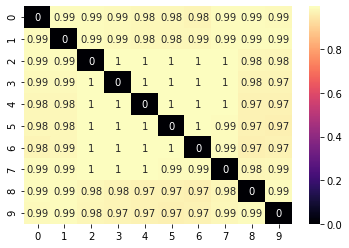

tensor([8, 9, 4, 5, 3, 3, 4, 2, 0, 1])
tensor([0.8888, 0.8900, 0.8931, 0.8911, 0.8898, 0.8884, 0.8885, 0.8924, 0.8834,
        0.8824])
tensor(2)


In [100]:
scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1)
            class_j = class_avgs[j].view(-1)
            scores[i,j] = cosine_similarity(class_i, class_j, dim=0)

sns.heatmap(scores, annot=True, cmap="magma")
plt.show()

print(scores.argmax(dim=0))
print(scores.mean(dim=1))
print(scores.mean(dim=1).argmax())

### Dot Product Similarity

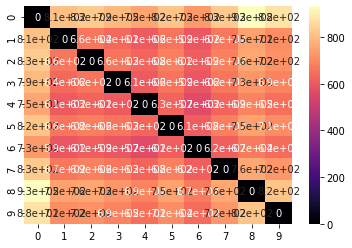

tensor([8, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([737.3531, 610.2699, 624.1873, 603.6008, 576.4905, 619.8812, 564.6127,
        625.9893, 686.1255, 654.6720])
tensor(0)


In [101]:
d_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            d_scores[i,j] = np.dot(class_i, class_j).astype(np.float64)

sns.heatmap(d_scores, annot=True, cmap="magma")
plt.show()

print(d_scores.argmax(dim=0))
print(d_scores.mean(dim=1))
print(d_scores.mean(dim=1).argmax())

### P-Norm Distance

p-norm: 0


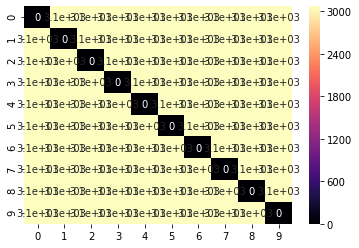

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([2764.8000, 2764.8000, 2764.8000, 2764.8000, 2764.8000, 2764.8000,
        2764.8000, 2764.8000, 2764.8000, 2764.8000])
tensor(9) 

p-norm: 1


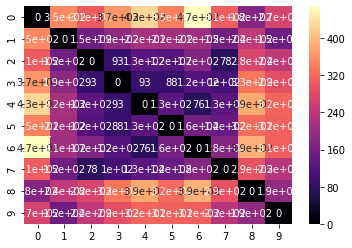

tensor([8, 9, 7, 5, 6, 3, 4, 2, 0, 1])
tensor([302.2643, 188.3949, 157.3931, 167.4520, 190.4084, 183.7906, 208.4549,
        162.7476, 261.5313, 232.2264])
tensor(2) 

p-norm: 2


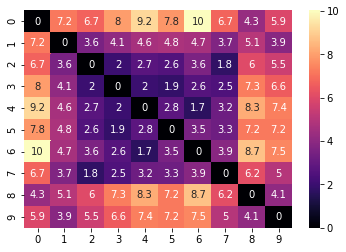

tensor([8, 2, 7, 5, 6, 3, 4, 2, 9, 1])
tensor([6.5832, 4.1550, 3.4535, 3.6953, 4.1917, 4.1096, 4.6263, 3.6240, 5.7187,
        5.3045])
tensor(2) 

p-norm: inf


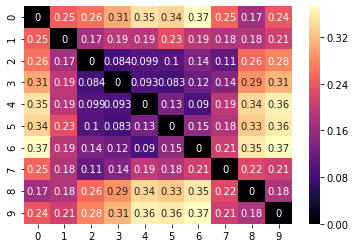

tensor([8, 2, 3, 5, 6, 3, 4, 2, 0, 8])
tensor([0.2537, 0.1792, 0.1496, 0.1623, 0.1850, 0.1903, 0.2000, 0.1701, 0.2323,
        0.2517])
tensor(2) 



In [102]:
p_norms = [0, 1, 2, np.inf]

for p in p_norms:
    
    print('p-norm:', p)
    p_scores = torch.zeros((num_classes, num_classes))
    
    for i in classes:
        for j in classes:
            
            if i !=j:
                class_i = class_avgs[i].view(-1)
                class_j = class_avgs[j].view(-1)
                stacked_classes = torch.stack((class_i, class_j))
                p_scores[i,j] = pdist(stacked_classes, p)

    sns.heatmap(p_scores, annot=True, cmap="magma")
    plt.show()

    print(p_scores.argsort()[:,1:2].view(-1))
    print(p_scores.mean(dim=1))
    print(p_scores.mean(dim=1).argmin(), '\n')

### Wasserstein Distance

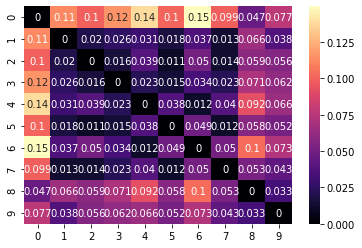

tensor([8, 7, 5, 5, 6, 2, 4, 5, 9, 8])
tensor([0.0940, 0.0362, 0.0366, 0.0387, 0.0480, 0.0353, 0.0557, 0.0347, 0.0583,
        0.0500])
tensor(7)


In [103]:
w_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            w_scores[i,j] = wasserstein_distance(class_i, class_j)

sns.heatmap(w_scores, annot=True, cmap="magma")
plt.show()

print(w_scores.argsort()[:,1:2].view(-1))
print(w_scores.mean(dim=1))
print(w_scores.mean(dim=1).argmin())

### Canberra Distance

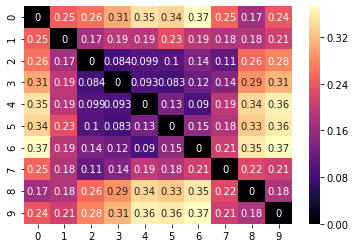

tensor([8, 2, 3, 5, 6, 3, 4, 2, 0, 8])
tensor([0.2537, 0.1792, 0.1496, 0.1623, 0.1850, 0.1903, 0.2000, 0.1701, 0.2323,
        0.2517])
tensor(2)


In [104]:
c_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            c_scores[i,j] = spatial.distance.chebyshev(class_i, class_j).astype(np.float64)

sns.heatmap(c_scores, annot=True, cmap="magma")
plt.show()

print(c_scores.argsort()[:,1:2].view(-1))
print(c_scores.mean(dim=1))
print(c_scores.mean(dim=1).argmin())

### Bray Curtis Distance

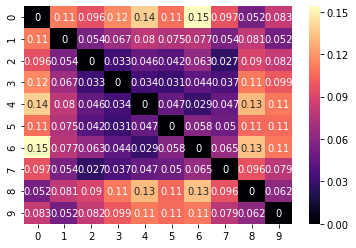

tensor([8, 9, 7, 5, 6, 3, 4, 2, 0, 1])
tensor([0.0956, 0.0651, 0.0533, 0.0572, 0.0664, 0.0623, 0.0736, 0.0552, 0.0864,
        0.0784])
tensor(2)


In [105]:
b_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            b_scores[i,j] = spatial.distance.braycurtis(class_i, class_j)

sns.heatmap(b_scores, annot=True, cmap="magma")
plt.show()

print(b_scores.argsort()[:,1:2].view(-1))
print(b_scores.mean(dim=1))
print(b_scores.mean(dim=1).argmin())